In [34]:
import numpy as np
import numba as nb
import pylab as pl

from numba import jit
import numpy.linalg as la

import h5py

import pandas as pd

import seaborn as sns

import site
site.addsitedir("./illustris_python/")
import illustris_python.groupcat as gc

In [35]:
# f = h5py.File('../data/TNG100-1/Subhalos/fof_subhalo_tab_084.0.hdf5')
# print(f['Subhalo'].keys())
# f.close()

In [36]:
# pos = np.loadtxt('./data/TracingTheCosmicWeb_PublicData/fof_catalog_200Mpc512.txt', skiprows=3, usecols=[1,2,3])
#----------- Selecting the subhalos (galaxies)
basePath = "../data/TNG100-1/Subhalos/"
subhalo_fields = ['SubhaloStarMetallicity','SubhaloVelDisp','SubhaloSFR','SubhaloFlag']#'SubhaloGasMetalFractions']
subhalos_features = gc.loadSubhalos(basePath, 84, fields=subhalo_fields)

star_metallicity = subhalos_features['SubhaloStarMetallicity']
veldisp = subhalos_features['SubhaloVelDisp']
sfr = subhalos_features['SubhaloSFR']
flag = subhalos_features['SubhaloFlag']

subhalo_fields = ['SubhaloPos','SubhaloVel','SubhaloSpin','SubhaloStellarPhotometrics','SubhaloGasMetalFractions']
subhalos_kinetics = gc.loadSubhalos(basePath, 84, fields=subhalo_fields)

position = subhalos_kinetics['SubhaloPos']

pos_x = subhalos_kinetics['SubhaloPos'][:,0]
pos_y = subhalos_kinetics['SubhaloPos'][:,1]
pos_z = subhalos_kinetics['SubhaloPos'][:,2]

vel_x = subhalos_kinetics['SubhaloVel'][:,0]
vel_y = subhalos_kinetics['SubhaloVel'][:,1]
vel_z = subhalos_kinetics['SubhaloVel'][:,2]

spin_x = subhalos_kinetics['SubhaloSpin'][:,0]
spin_y = subhalos_kinetics['SubhaloSpin'][:,1]
spin_z = subhalos_kinetics['SubhaloSpin'][:,2]

tng_U =  subhalos_kinetics['SubhaloStellarPhotometrics'][:,0]
tng_B =  subhalos_kinetics['SubhaloStellarPhotometrics'][:,1]
tng_V =  subhalos_kinetics['SubhaloStellarPhotometrics'][:,2]
tng_K =  subhalos_kinetics['SubhaloStellarPhotometrics'][:,3]
tng_g =  subhalos_kinetics['SubhaloStellarPhotometrics'][:,4]
tng_r =  subhalos_kinetics['SubhaloStellarPhotometrics'][:,5]
tng_i =  subhalos_kinetics['SubhaloStellarPhotometrics'][:,6]
tng_z =  subhalos_kinetics['SubhaloStellarPhotometrics'][:,7]

# GMF =  subhalos_kinetics['SubhaloGasMetalFractions']

header = gc.loadHeader(basePath, 84)
N_real = len(position)
subhalo_ids = np.arange(0,len(position),1)

del subhalos_features, subhalos_kinetics

In [37]:
# df = pd.DataFrame( np.c_[ subhalo_ids, pos_x, pos_y, pos_z, vel_x, vel_y, vel_z, spin_x, spin_y, spin_z, tng_U, tng_B, tng_V, tng_K, tng_g, tng_r, tng_i, tng_z, star_metallicity, veldisp, sfr, flag],
#                   columns = ['ID', 'pos_x', 'pos_y', 'pos_z', 'vel_x', 'vel_y', 'vel_z', 'spin_x', 'spin_y', 'spin_z', 'tng_MU', 'tng_MB', 'tng_MV', 'tng_MK', 'tng_Mg', 'tng_Mr', 'tng_Mi', 'tng_Mz', 'star_metallicity', 'veldisp', 'sfr', 'flag'])
# df.to_csv('./data/tng_features.csv')

In [5]:
header

{'BoxSize': 75000.0,
 'FlagDoubleprecision': 0,
 'Git_commit': b'd203ec8b07c7e2bdda5f608aa0babea46d603699',
 'Git_date': b'Thu Apr 7 14:14:27 2016 +0200',
 'HubbleParam': 0.6774,
 'Ngroups_ThisFile': 1,
 'Ngroups_Total': 6457890,
 'Nids_ThisFile': 10984939,
 'Nids_Total': 4944896937,
 'Nsubgroups_ThisFile': 13069,
 'Nsubgroups_Total': 4527127,
 'NumFiles': 448,
 'Omega0': 0.3089,
 'OmegaLambda': 0.6911,
 'Redshift': 0.19728418237600986,
 'Time': 0.8352235958012078}

In [6]:
ngrid = 256
Lbox = 75 #cMpc/h
Lbox

75

In [7]:
pos = position/1000 #

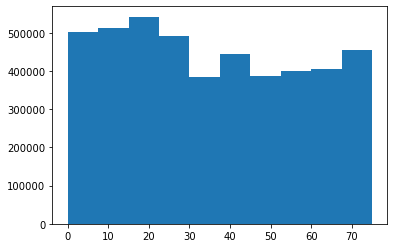

In [8]:
_ = pl.hist(pos[:,0])

In [9]:
cellsize = Lbox / ngrid
cellsize #cMpc/h

0.29296875

In [10]:
volume = 75.0 ** 3 #(cMpc/h)^3
volume

421875.0

In [11]:
meandensity = len(pos) / volume
meandensity

10.730967703703703

In [12]:
density, bins = np.histogramdd(pos, bins=ngrid, range=None, normed=None, weights=None, density=None)
density.shape

(256, 256, 256)

In [13]:
deltas = (density / meandensity) - 1.
np.shape(deltas)

(256, 256, 256)

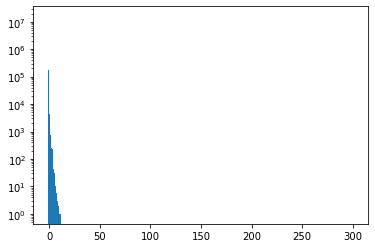

In [14]:
_= pl.hist(deltas.flatten(), bins=np.arange(-1,300,0.1))
pl.yscale('log')

In [15]:
def Wg(k2, R):
    return np.exp(-k2*R*R/2.)

def get_fourier_smooth(density,R_smooth,N_dim,Lbox):
    karr = np.fft.fftfreq(N_dim, d=Lbox/(2*np.pi*N_dim))
    d_four = np.fft.fftn(density)
    del density
    
    #dksmo = np.zeros(shape=(N_dim, N_dim, N_dim),dtype=complex)
    ksq = np.zeros(shape=(N_dim, N_dim, N_dim),dtype=complex)
    ksq[:,:,:] = karr[None,None,:]**2+karr[None,:,None]**2+karr[:,None,None]**2
    d_four[:,:,:] = Wg(ksq,R_smooth)*d_four

    return karr, ksq, d_four

In [16]:
karr, ksd, d_four = get_fourier_smooth(deltas, R_smooth=cellsize, N_dim=ngrid, Lbox=Lbox)

In [17]:
ksd.shape

(256, 256, 256)

In [18]:
@jit(nopython=True)
def get_tidal_field(dfour,karr,N_dim):
    tfour = np.zeros(shape=(N_dim, N_dim, N_dim, 3, 3), dtype=nb.complex128)
    
    # computing tidal tensor and phi in fourier space
    # and smoothing using the window functions
    for a in range(N_dim):
        for b in range(N_dim):
            for c in range(N_dim):
                if (a, b, c) == (0, 0, 0):
                    pass
                else:
                    ksq = karr[a]**2 + karr[b]**2 + karr[c]**2
                    # all 9 components
                    tfour[a, b, c, 0, 0] = karr[a]*karr[a]*dfour[a, b, c]/ksq
                    tfour[a, b, c, 1, 1] = karr[b]*karr[b]*dfour[a, b, c]/ksq
                    tfour[a, b, c, 2, 2] = karr[c]*karr[c]*dfour[a, b, c]/ksq
                    tfour[a, b, c, 1, 0] = karr[a]*karr[b]*dfour[a, b, c]/ksq
                    tfour[a, b, c, 0, 1] = tfour[a, b, c, 1, 0]
                    tfour[a, b, c, 2, 0] = karr[a]*karr[c]*dfour[a, b, c]/ksq
                    tfour[a, b, c, 0, 2] = tfour[a, b, c, 2, 0]
                    tfour[a, b, c, 1, 2] = karr[b]*karr[c]*dfour[a, b, c]/ksq
                    tfour[a, b, c, 2, 1] = tfour[a, b, c, 1, 2]

    return tfour

In [19]:
tidal_tilde = get_tidal_field(d_four,karr,ngrid)
# tidal_tilde

In [20]:
tidal_real = np.zeros(shape=(ngrid, ngrid, ngrid, 3, 3),dtype=float) # Normalized by 4. * np.pi * 6.6743e-11

In [21]:
for i in range(3):
    for j in range(3):
        tidal_real[:,:,:,i,j] = np.real(np.fft.ifftn(tidal_tilde[:,:,:,i,j]))

In [22]:
def get_eig(tidt, N_dim):
    evals = np.zeros(shape=(N_dim, N_dim, N_dim, 3))

    for x in range(N_dim):
        for y in range(N_dim):
            for z in range(N_dim):
                # comute and sort evalues in ascending order, for descending add after argsort()[::-1]
                evals[x, y, z, :], evects = la.eig(tidt[x, y, z, :, :])
                idx = evals[x, y, z, :].argsort()
                evals[x, y, z] = evals[x, y, z, idx]
                #evects = evects[:, idx]
    
    lambda1 = evals[:,:,:,0]
    lambda2 = evals[:,:,:,1]
    lambda3 = evals[:,:,:,2]

    return lambda1, lambda2, lambda3

In [23]:
lambda1, lambda2, lambda3 = get_eig(tidal_real, ngrid)

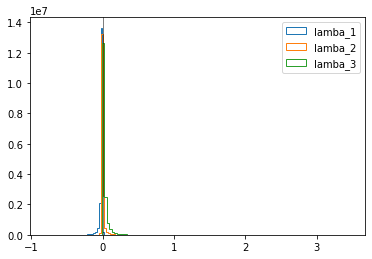

In [24]:
lth = 0.2/1000

_ = pl.hist(lambda1.flatten(), histtype='step', bins=100, label='lamba_1')
_ = pl.hist(lambda2.flatten(), histtype='step', bins=100, label='lamba_2')
_ = pl.hist(lambda3.flatten(), histtype='step', bins=100, label='lamba_3')

pl.axvline(lth, c='k', lw=0.5)
pl.legend()

In [25]:
ii_box = (pos[:,0]//cellsize).astype(int)
jj_box = (pos[:,1]//cellsize).astype(int)
kk_box = (pos[:,2]//cellsize).astype(int)

lambda1_halo = lambda1[ii_box, jj_box, kk_box]
lambda2_halo = lambda2[ii_box, jj_box, kk_box]
lambda3_halo = lambda3[ii_box, jj_box, kk_box]

## T-Web Definition

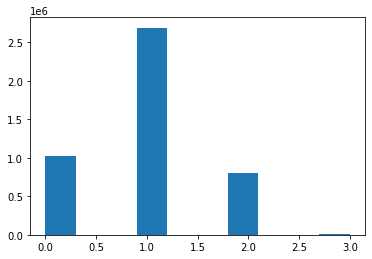

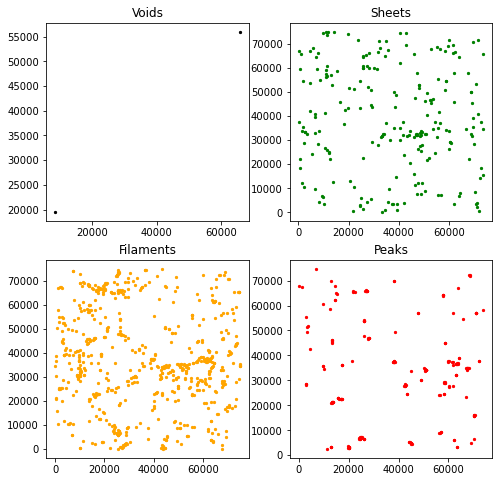

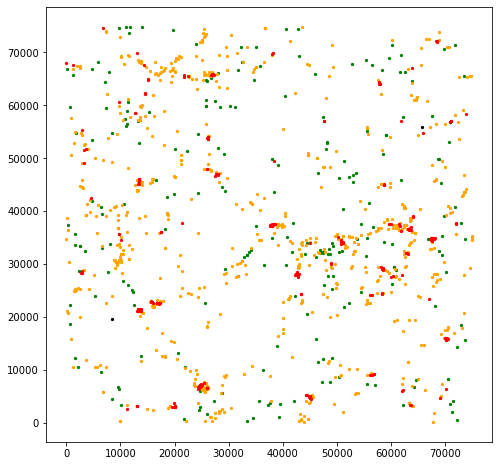

In [26]:
environment = np.zeros(len(pos), dtype=int)

# Attached the environment to the galaxies
ii_void = (lambda1_halo < lth) & (lambda2_halo < lth) & (lambda3_halo < lth)
ii_sheet = (lambda3_halo > lth) & (lambda2_halo < lth) & (lambda1_halo < lth)
ii_filament = (lambda3_halo > lth) & (lambda2_halo > lth) & (lambda1_halo < lth)
ii_peak = (lambda1_halo > lth) & (lambda2_halo > lth) & (lambda3_halo > lth)
environment[ii_void] = 3
environment[ii_sheet] = 2        
environment[ii_filament] = 1        
environment[ii_peak] = 0

_ = pl.hist(environment)

is_slice = (position[:,2] < 100.)  &   (position[:,2] > 80.) #Mpc
is_void     = environment == 3
is_sheet    = environment == 2
is_filament = environment == 1
is_peak     = environment == 0

fig = pl.figure(figsize=(8,8))
pl.subplot(2,2,1)
pl.scatter(position[:,0][is_void & is_slice] , position[:,1][is_void & is_slice], s=5, c='k')
pl.title('Voids')
pl.subplot(2,2,2)
pl.scatter(position[:,0][is_sheet & is_slice] , position[:,1][is_sheet & is_slice], s=5, c='g')
pl.title('Sheets')
pl.subplot(2,2,3)
pl.scatter(position[:,0][is_filament & is_slice] , position[:,1][is_filament & is_slice], s=5, c='orange')
pl.title('Filaments')
pl.subplot(2,2,4)
pl.scatter(position[:,0][is_peak & is_slice] , position[:,1][is_peak & is_slice], s=5, c='r')
pl.title('Peaks')
pl.show()

fig = pl.figure(figsize=(8,8))
pl.scatter(position[:,0][is_void & is_slice] , position[:,1][is_void & is_slice], s=5, c='k')
pl.scatter(position[:,0][is_sheet & is_slice] , position[:,1][is_sheet & is_slice], s=5, c='g')
pl.scatter(position[:,0][is_filament & is_slice] , position[:,1][is_filament & is_slice], s=5, c='orange')
pl.scatter(position[:,0][is_peak & is_slice] , position[:,1][is_peak & is_slice], s=5, c='r')
pl.show()

In [27]:
delta_color = deltas[ii_box, jj_box, kk_box]

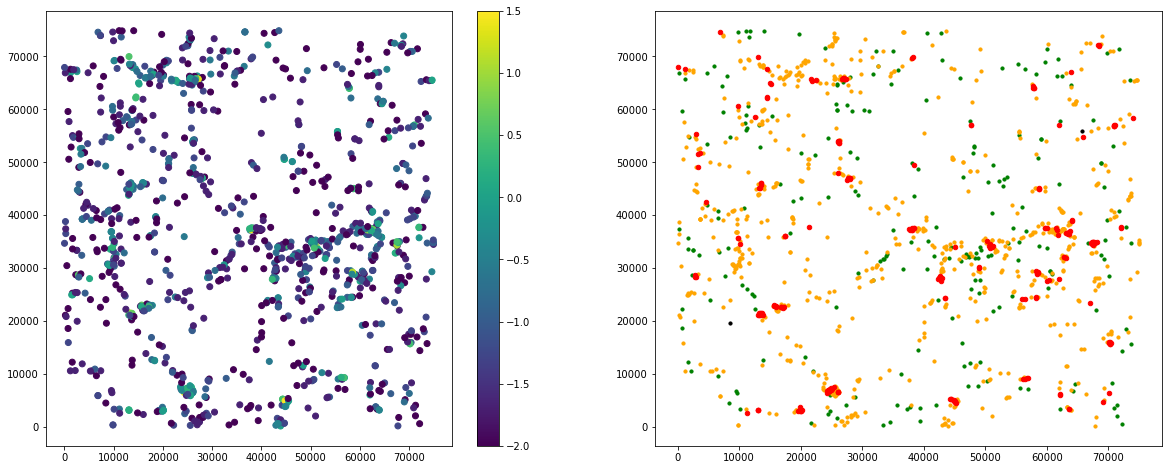

In [33]:
fig = pl.figure(figsize=(20,8))
pl.subplot(1,2,1)
pl.scatter(position[:,0][is_slice], position[:,1][is_slice], c=np.log(1+delta_color[is_slice]), vmin=-2., vmax=1.5)
pl.colorbar()
pl.subplot(1,2,2)
pl.scatter(position[:,0][is_void & is_slice] , position[:,1][is_void & is_slice], s=10, c='k')
pl.scatter(position[:,0][is_sheet & is_slice] , position[:,1][is_sheet & is_slice], s=10, c='g')
pl.scatter(position[:,0][is_filament & is_slice] , position[:,1][is_filament & is_slice], s=10, c='orange')
pl.scatter(position[:,0][is_peak & is_slice] , position[:,1][is_peak & is_slice], s=20, c='r')
pl.show()

In [29]:
df = pd.DataFrame(np.c_[subhalo_ids,lambda1_halo, lambda2_halo, lambda3_halo, delta_color, environment], columns=['ID','lambda1','lambda2','lambda3','delta','Environment'])
df.to_csv(f'./data/tweb_cw_grid{ngrid}_rcellsize.csv')

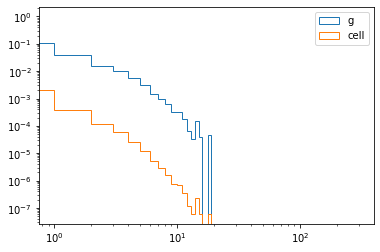

In [30]:
_ = pl.hist(df['delta'], histtype='step', density=True, bins =np.arange(-1., 300., 1.), label='g')
_ = pl.hist(deltas.flatten(), histtype='step', density=True, bins =np.arange(-1., 300., 1.), label='cell')

pl.xscale('log')
pl.yscale('log')

pl.legend()

In [31]:
# values = ['lambda1','lambda2','lambda3','delta']
# sns.pairplot(df[values], hue='delta')